# $\textbf{Worksheet 09}$

$\textbf{Name: Sabarno Saha}\\$
$\textbf{Roll: 22MS037}$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft
import scienceplots
from matplotlib.animation import FuncAnimation
plt.style.use("science")
plt.rcParams.update({"font.size":20})
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

# Question 1

Find the **Fast Fourier Transform** of the following potentials,
- A single step potential
- A double step potential

In [2]:
xmin = -5
xmax = 5
xr = -40
xl = 40
val =1

In [3]:
# Single Step potential
def b(x):
    if xmin<x<xmax:
        return val
    return 0


In [4]:
# Double Step potential
def b2(x):
    if xmin<x-15<xmax or xmin<x+15<xmax:
        return val
    return 0
    

In [5]:
xval = np.linspace(xl,xr,4000)
y = np.asarray([b(i) for i in xval])
y2 = np.asarray([b2(i) for i in xval])

In [6]:
fy = fft.fftshift(fft.fft(fft.ifftshift(y)))
fy2 = fft.fftshift(fft.fft(fft.ifftshift(y2)))

/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-5.0, 5.0)

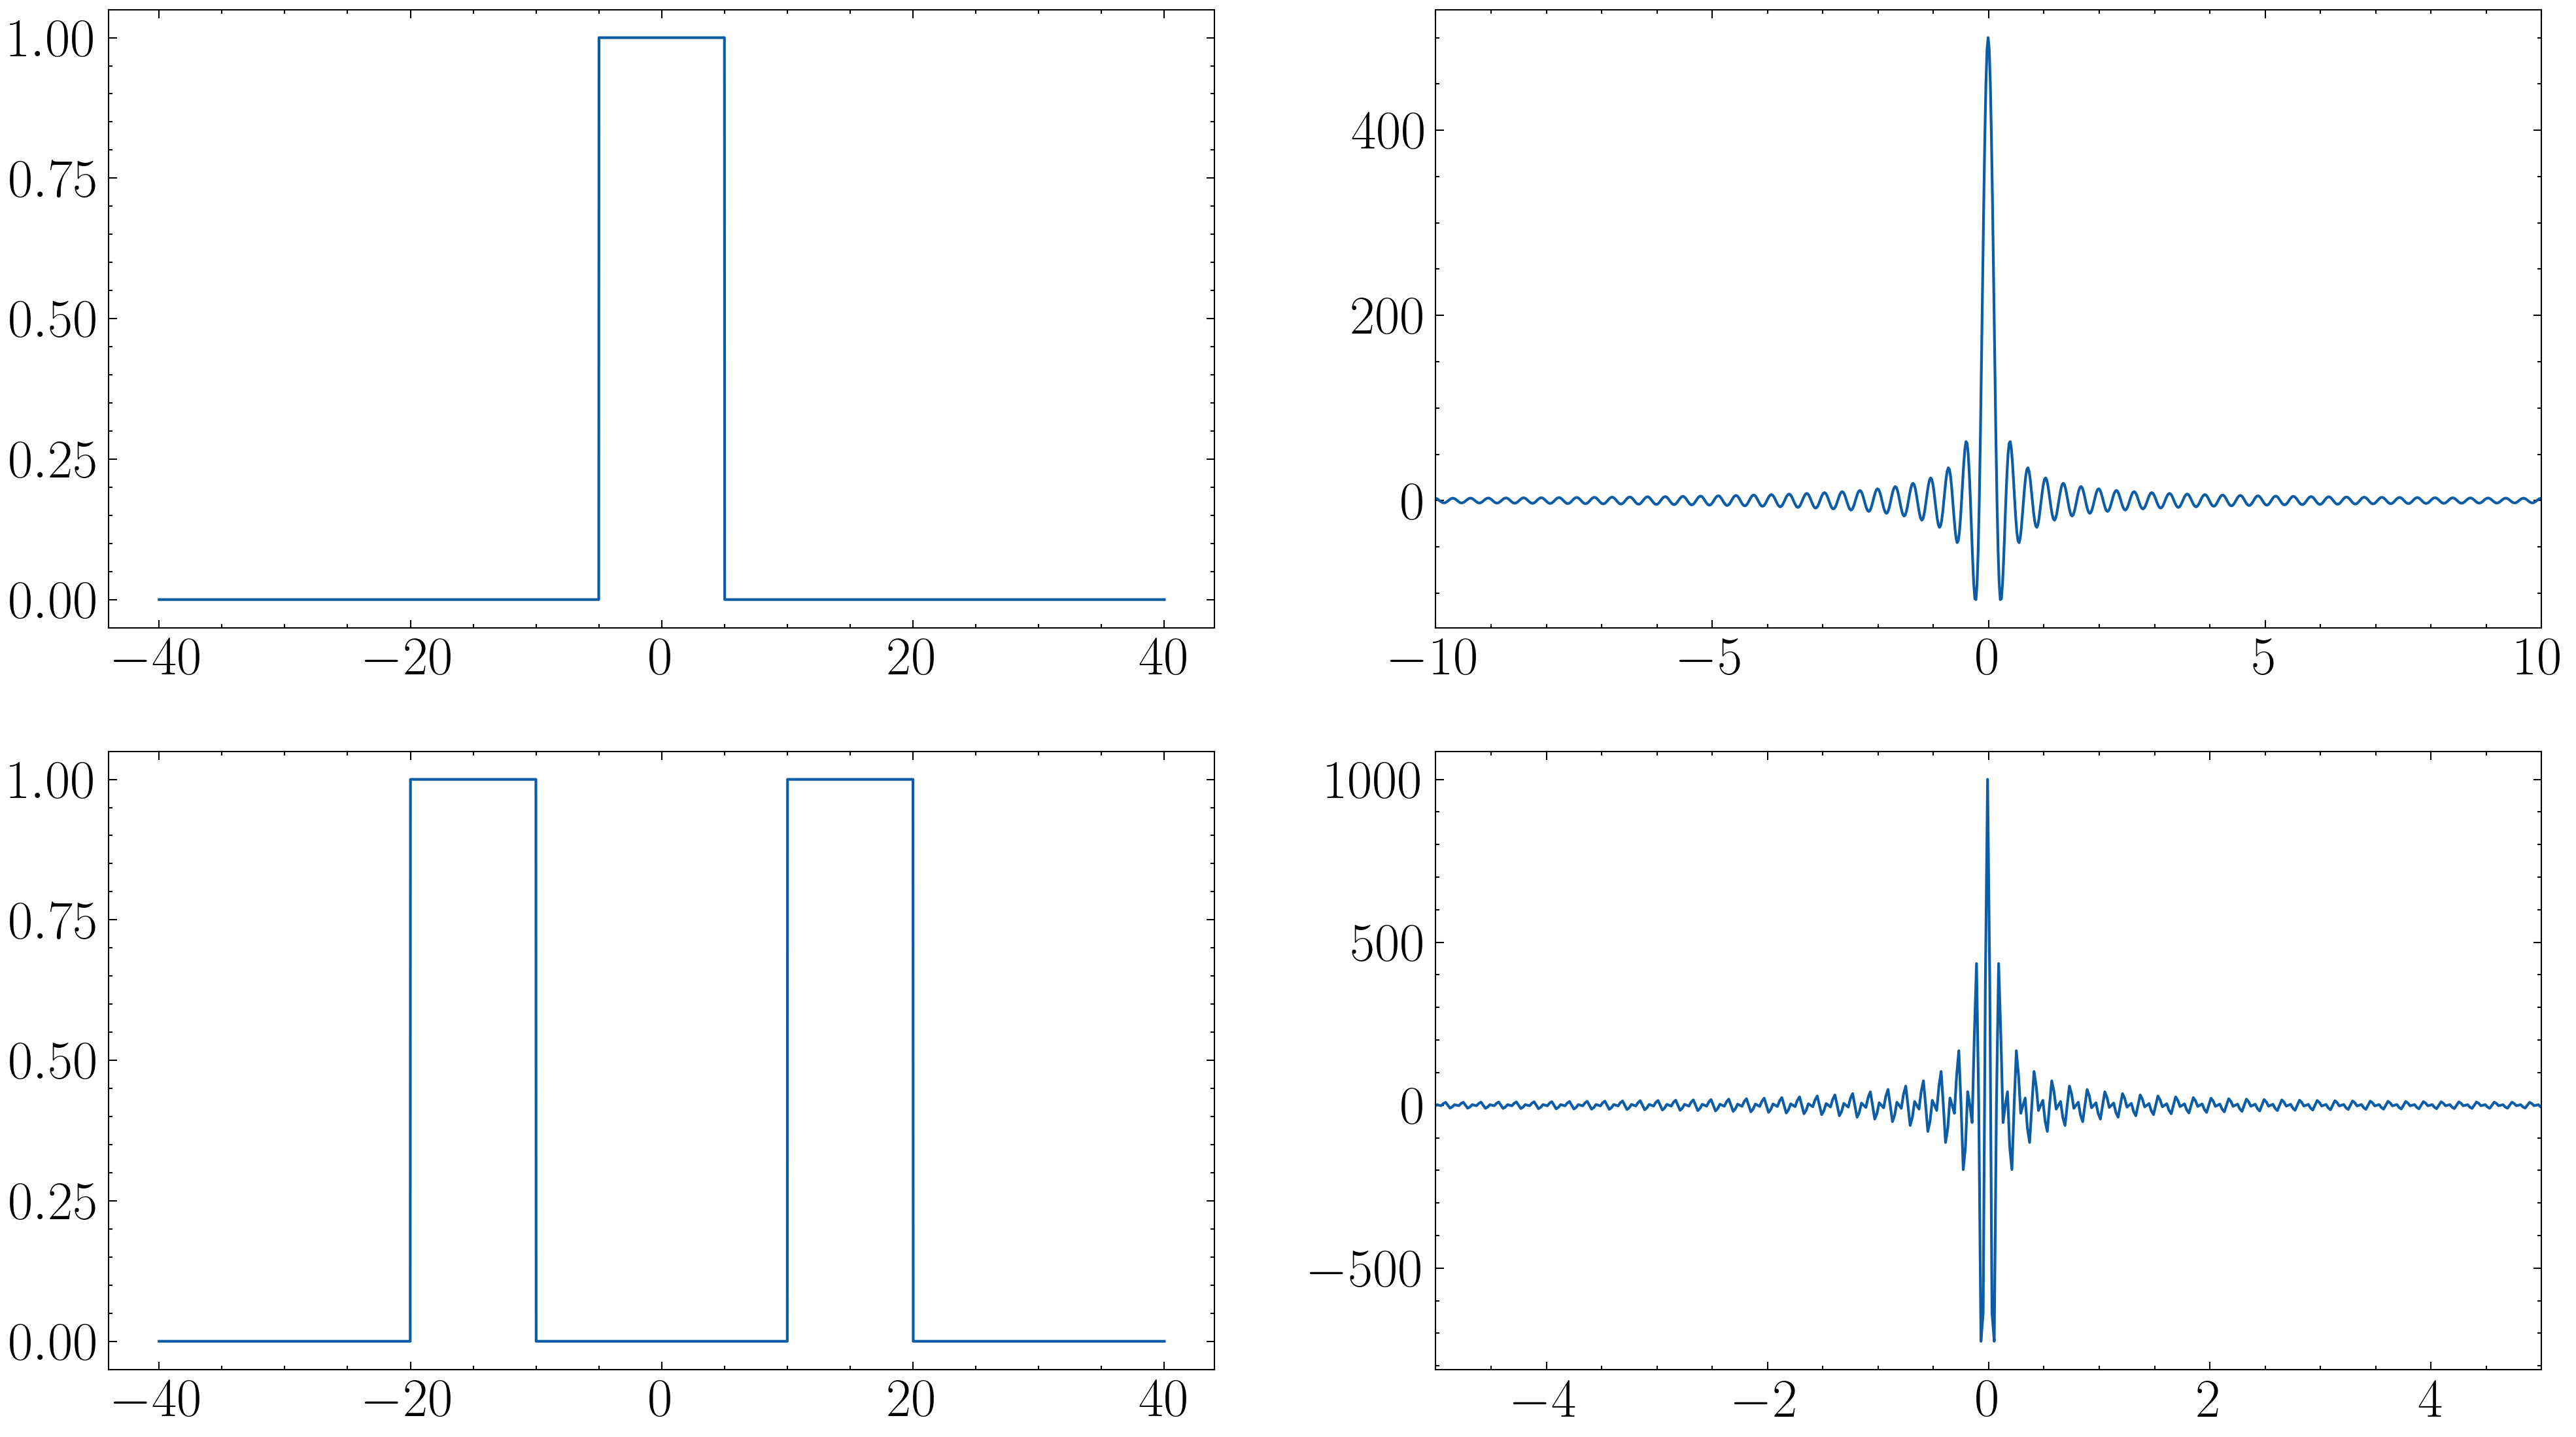

In [7]:
fig, axes = plt.subplots(2,2, figsize = (16,9), dpi = 300)
axes[0,0].plot(xval,y)
axes[0,1].plot(xval,fy)
axes[0,1].set_xlim((-10,10))
axes[1,1].plot(xval,fy2)
# axes[0,1].plot(xval,fy)
axes[1,0].plot(xval, y2)
axes[1,1].set_xlim((-5,5))


# Question 2:

- $\textbf{Step Potential}$ $$ V=\begin{cases}
			0, & \text{x<5 or x>7}\\
            V_0, & \text{5<x<7}
		 \end{cases} 
         $$
- $\textbf{Quadratic Potential}$ \\
    $$V = 0.1 \times x^2$$

In [8]:
###############################################################################
# 1. Physical / Numerical Parameters
###############################################################################
ħ = 1.0 # Reduced Planck's constant (units)
m = 1.0 # Particle mass (units)
Nx = 512 # Number of spatial grid points
x_min = -20.0
x_max = 20.0
L = x_max - x_min
dx = L / Nx
dt = 0.0025 # Time step
n_steps = 500 # Number of time steps
plot_every = 1 # Store/plot wavefunction every 'plot_every' steps


In [9]:

x = np.linspace(x_min, x_max, Nx, endpoint=False)
dk = 2.0 * np.pi / L
# Create wave-number array:
# indices 0..(Nx/2) increasing positive wavenumbers,
# indices (Nx/2+1).. Nx-1 negative wavenumbers, etc.
k_vals = np.fft.fftfreq(Nx, d=dx) * 2.0 * np.pi


In [10]:

def finite_square_well(x, left_edge, right_edge, V0):
    """
    Returns a 1D potential array with a 'square well' from [left_edge,right_edge]
    of depth -V0 (i.e. negative potential).
    """
    V = np.zeros_like(x)
    mask = (x >= left_edge) & (x <= right_edge)
    V[mask] = V0
    return V
V0 = 40.0 # well depth
well_left = 5.0
well_right = 7.0
V = finite_square_well(x, well_left, well_right, V0)


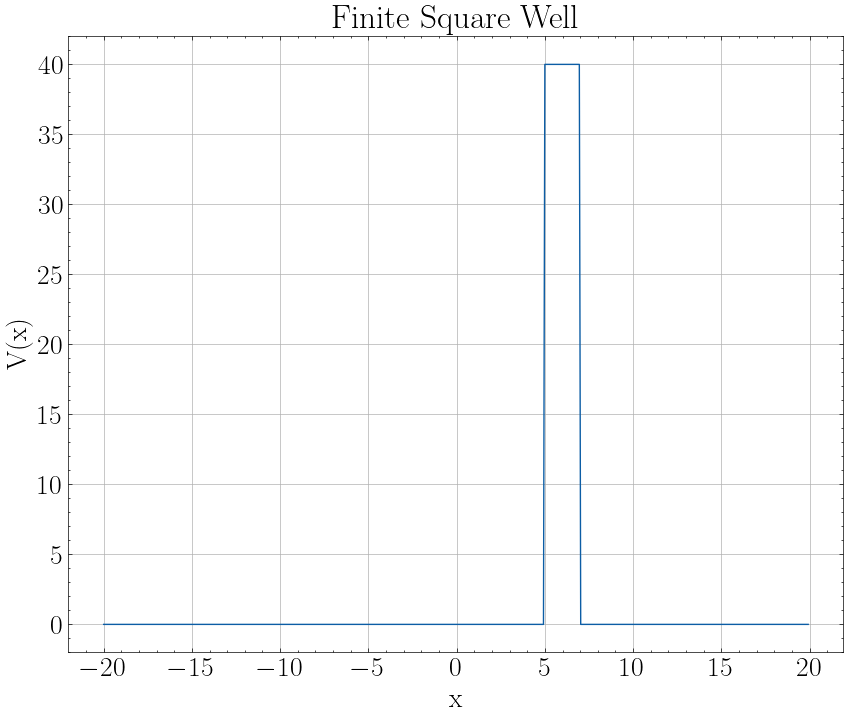

In [11]:
xv = np.linspace(x_min, x_max, Nx, endpoint=False)
v = np.asarray([finite_square_well(i,well_left,well_right,V0) for i in xv])
plt.figure(figsize=(10,8), dpi=100)
plt.plot(xv,v)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Finite Square Well")
plt.grid()

In [12]:

x0 = -5.0 # initial center
sigma = 0.04
k0 = 3.0 # wave number -> momentum p = ħ*k0
def initial_gaussian_packet(x, x0, sigma, k0):
    """
    Returns a Gaussian wave packet centered at x0,
    with standard dev sigma, plane-wave factor e^{i k0 x}.
    """
    # Normalization factor is flexible; for large domains, we can skip it
    # or just do approximate normalization.
    norm_factor = 1.0 / (np.sqrt(sigma * np.sqrt(np.pi)))
    return norm_factor * np.exp(-0.5 * ((x - x0)/sigma)**2) * np.exp(1j * k0 * x)
psi = initial_gaussian_packet(x, x0, sigma, k0)


In [13]:

def split_operator_step(psi, V, dt, k_vals):
    """
    Performs one Strang-split time step:
    1) half-step kinetic
    2) full-step potential
    3) half-step kinetic
    psi : current wavefunction in real space
    V : potential array
    dt : time step
    k_vals : array of wave numbers
    """
    # 1) Half-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    # E_kin(k) = ħ^2 * k^2 / (2m)
    E_kin = (ħ**2 * k_vals**2) / (2.0 * m)
    # multiply by exp(-i E_kin dt/(2ħ))
    psi_k *= np.exp(-0.5j * E_kin * dt / ħ)
    psi = np.fft.ifft(psi_k)
    # 2) Full-step in potential (real) space
    # multiply by exp(-i V dt / ħ)
    psi *= np.exp(-1j * V * dt / ħ)
    # 3) Another half-step in kinetic
    psi_k = np.fft.fft(psi)
    psi_k *= np.exp(-0.5j * E_kin * dt / ħ)
    psi = np.fft.ifft(psi_k)
    return psi

snapshots = []
snapshots.append(psi.copy()) # store initial wavefunction
for step in range(1, n_steps + 1):
    psi = split_operator_step(psi, V, dt, k_vals)
    # Optionally check or normalize wavefunction:
    # norm_psi = np.sum(np.abs(psi)**2)*dx
    # psi /= np.sqrt(norm_psi)
    if step % plot_every == 0:
       snapshots.append(psi.copy())


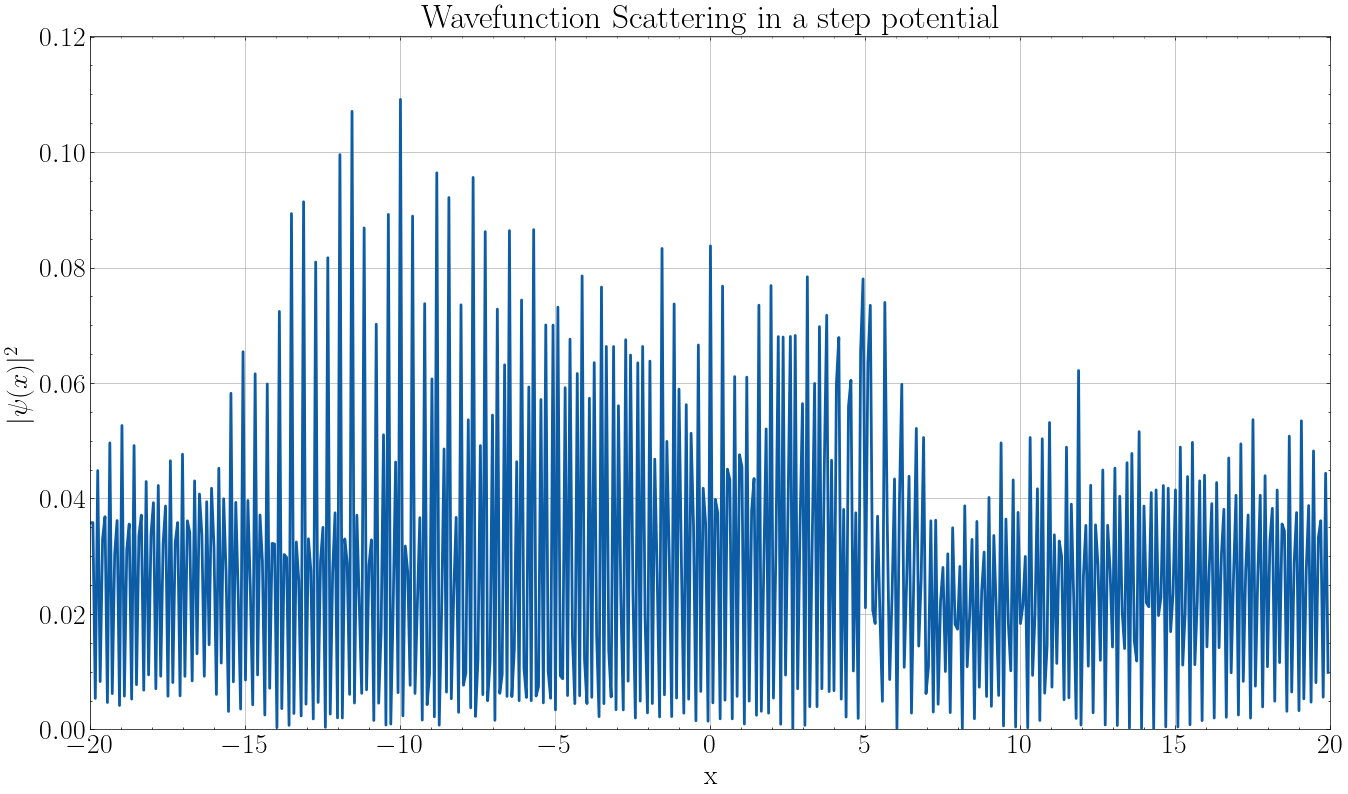

In [14]:

fig, ax = plt.subplots(figsize=(16,9))
line, = ax.plot(x, np.abs(snapshots[0])**2, lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 1.1 * np.max(np.abs(snapshots[0])**2))
ax.set_xlabel("x")
# ax.set_ylabel("| |^2")
def update(frame):
    # frame is an index into snapshots
    psi_current = snapshots[frame]
    prob_density = np.abs(psi_current)**2
    line.set_ydata(prob_density)
    ax.set_ylim(0, 1.1 * np.max(prob_density))
    ax.set_title(f"Scattering Step: {frame*plot_every}")
    return line,

ani = FuncAnimation(fig, update, frames=len(snapshots), blit=False,interval=100)
# Save as GIF (requires "pillow" or "imagemagick" installed)
ani.save("wavefunction_scattering_2.gif", writer="pillow", fps=20)
plt.xlabel("x")
plt.ylabel(r"$|\psi(x)|^2$")
plt.grid()
plt.title("Wavefunction Scattering")
plt.title("Wavefunction Scattering in a step potential")
plt.show()

In [15]:
V2 = x**2

In [16]:
psi = initial_gaussian_packet(x, x0, sigma, k0)

snapshots = []
snapshots.append(psi.copy()) # store initial wavefunction
for step in range(1, n_steps + 1):
    psi = split_operator_step(psi, V2, dt, k_vals)
    # Optionally check or normalize wavefunction:
    # norm_psi = np.sum(np.abs(psi)**2)*dx
    # psi /= np.sqrt(norm_psi)
    if step % plot_every == 0:
       snapshots.append(psi.copy())

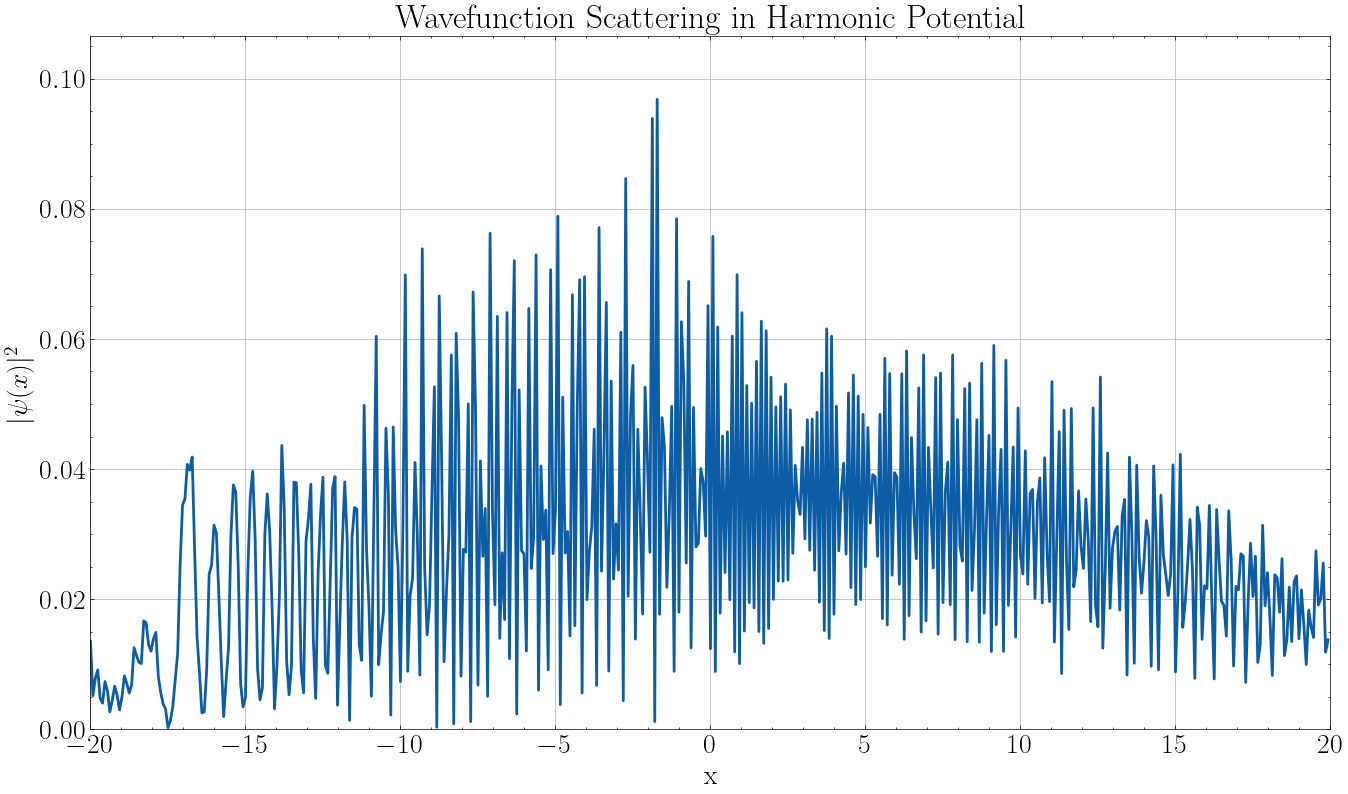

In [17]:

fig1, ax = plt.subplots(figsize=(16,9))
line, = ax.plot(x, np.abs(snapshots[0])**2, lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 1.1 * np.max(np.abs(snapshots[0])**2))
ax.set_xlabel("x")
# ax.set_ylabel("| |^2")
def update(frame):
    # frame is an index into snapshots
    psi_current = snapshots[frame]
    prob_density = np.abs(psi_current)**2
    line.set_ydata(prob_density)
    ax.set_ylim(0, 1.1 * np.max(prob_density))
    ax.set_title(f"Scattering Step: {frame*plot_every}")
    return line,

ani1 = FuncAnimation(fig1, update, frames=len(snapshots), blit=False,interval=100)
# Save as GIF (requires "pillow" or "imagemagick" installed)
ani1.save("wavefunction_scattering.gif", writer="pillow", fps=20)
plt.xlabel("x")
plt.ylabel(r"$|\psi(x)|^2$")
plt.grid()
plt.title("Wavefunction Scattering in Harmonic Potential")
plt.show()